In [ ]:
####Following timeframes intervals are supported-

Interval.in_1_minute

Interval.in_3_minute

Interval.in_5_minute

Interval.in_15_minute

Interval.in_30_minute

Interval.in_45_minute

Interval.in_1_hour

Interval.in_2_hour

Interval.in_3_hour

Interval.in_4_hour

Interval.in_daily

Interval.in_weekly

Interval.in_monthly

extended_price_data = tv.get_hist(symbol="",exchange="BMFBOVESPA",interval=Interval.in_daily,n_bars=500, extended_session=False)

ERROR:tvDatafeed.main:error while signin


Resultados do Backtesting:
Data Inicial: 2021-03-01
Data Final: 2024-04-24
Saldo inicial: $10,000.00
Saldo final para ASAI3: $12,355.11
Quantidade de Trades Vencedores: 164
Quantidade de Trades Perdedores: 93
Assertividade (%): 63.81%
Drawdown Máximo (%): 34.35%
Variação Percentual do Capital: 23.55%

Log de Operações com Lucro/Prejuízo:


,Buy_Date,Buy_Price,Shares,Balance,Sell_Date,Sell_Price,Profit
0,2021-03-08,14.068848,710,10313.021960,2021-03-08,14.509724,313.021960
1,2021-03-08,14.039457,734,9895.933066,2021-03-09,13.471216,-417.088894
2,2021-03-15,14.119794,700,10016.635466,2021-03-15,14.292226,120.702400
3,2021-03-16,14.119794,709,10145.835827,2021-03-17,14.302023,129.200361
4,2021-03-19,13.990470,725,9905.754252,2021-03-22,13.659323,-240.081575
5,2021-03-24,13.516284,732,10021.933632,2021-03-25,13.674999,116.179380
6,2021-03-31,14.111956,710,10248.700532,2021-03-31,14.431346,226.766900
7,2021-04-07,14.731142,695,10014.468157,2021-04-07,14.394117,-234.232375
8,2021-04-22,15.738299,636,10165.259941,2021-04-22,15.975393,150.791784
9,2021-04-23,15.763772,644,10276.306149,2021-04-23,15.936204,111.046208


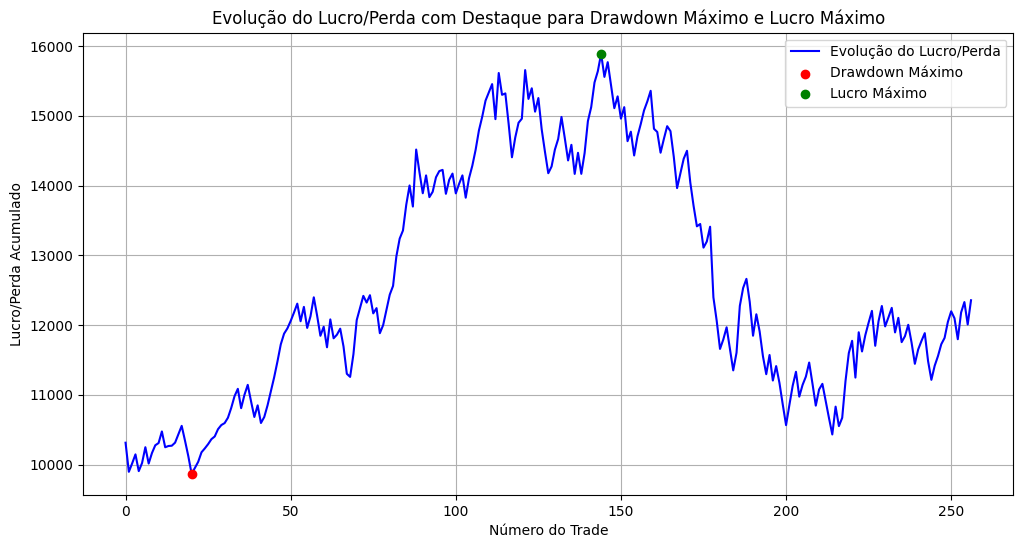

In [11]:
from tvDatafeed import TvDatafeed, Interval
import pandas as pd
import numpy as np
from pandas_ta import rsi
import math
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
from IPython.display import display, HTML
import plotly.graph_objects as go
from plotly.subplots import make_subplots



# Inicializar TvDatafeed
username = os.getenv('TRADINGVIEW_USERNAME')
password = os.getenv('TRADINGVIEW_PASSWORD')
tv = TvDatafeed(username, password)
# Configurações 
initial_capital = 10000 # Capital Inicial
length = 20   # Quantidade de períodos utilizados para calcular a média móvel da banda central 
std_dev = 1   # Quantidade de desvios padrões para cálculo das bandas inferior e superior 
ticker = 'ASAI3'
stop_loss_percent = 2 
# Essa função roda a estratégia das Bandas de Bollinger definida pelos parâmetros

def backtest_bollinger_strategy(data, initial_capital, stop_loss_percent):
    capital = initial_capital
    position = 0
    trade_log = []
    in_trade = False
    buy_price = 0

    for i in range(1, len(data)):
        current_row = data.iloc[i]
        previous_row = data.iloc[i-1]

        if in_trade:
            loss = (buy_price - current_row['close']) / buy_price * 100
            if loss >= stop_loss_percent:
                # Lógica de cálculo do saldo (posição x fechamento)
                capital += position * current_row['close']
                # Calculo do Resultado após acionamento do stop 
                profit_loss = buy_info['Shares'] * (current_row['close'] - buy_info['Buy_Price'])
                # Pega as chaves do dicionário buy_info e adiciona ao novo dicionário trade_log junto das novas info
                trade_log.append({**buy_info, 'Sell_Date': current_row.name, 'Sell_Price': current_row['close'], 'Balance': capital, 'Profit': profit_loss})
                buy_info = None   #Reset
                position = 0      #Reset
                in_trade = False #Reset
                buy_price = 0  # Reset 
                continue
        # Acionamento de compra por preço estar abaixo da banda inferior
        if not in_trade and current_row['close'] < current_row['lower_band'] and previous_row['close'] > previous_row['lower_band']:
            # Lógica de compra, math.floor() arredonda até o número inteiro para baixo mais próximo
            shares_to_buy = math.floor(capital / current_row['close'])
            # Atualiza o capital após definirmos a quantidade de ações a ser comprada 
            capital -= shares_to_buy * current_row['close']
            # Adiciona as ações a serem compradas a variavel da posição e atualiza o booleano in_trade
            position += shares_to_buy
            in_trade = True
            buy_price = current_row['close']  # Definir buy_price com o preço da linha do sinal de compra
            # Atualiza o dicionário buy_info com as informações da compra
            buy_info = {'Buy_Date': current_row.name, 'Buy_Price': current_row['close'], 'Shares': shares_to_buy, 'Balance': capital}
        # Acionamento de venda pelo preço estar acima da banda da média móvel (take gain)
        elif in_trade and current_row['close'] > current_row['middle_band']:
            # Lógica de venda começa atualizando o capital com o preço da linha do sinal de venda
            capital += position * current_row['close']
            if buy_info:
                #Atualiza variavel de ganho/perda com o resultado ( qtd * ( preço venda - preço compra))
                profit_loss = buy_info['Shares'] * (current_row['close'] - buy_info['Buy_Price'])
                # Pega as chaves do dicionário buy_info e adiciona ao novo dicionário trade_log junto das novas info
                trade_log.append({**buy_info, 'Sell_Date': current_row.name, 'Sell_Price': current_row['close'], 'Balance': capital, 'Profit': profit_loss})
                buy_info = None
                position = 0
                in_trade = False
                buy_price = 0  # Reset buy_price
    # Calcula o saldo final somando o capital final ao valor da posição final caso esteja em aberto 
    final_balance = capital + (position * data.iloc[-1]['close'] if position > 0 else 0)
    return trade_log, final_balance

## Esta função calcula métricas adicionais a partir do log de trades gerado pela função de backtesting.

def calculate_additional_metrics(trade_log, initial_capital):
    # Inicializa contadores para trades vencedores e perdedores
    winning_trades = 0
    losing_trades = 0
    # Lista para armazenar os drawdowns ocorridos ao longo das trades
    drawdowns = []
    # O pico do saldo é inicializado com o capital inicial para acompanhar o maior saldo alcançado
    peak_balance = initial_capital

    # Itera sobre cada trade no log de trades
    for trade in trade_log:
        final_balance = trade['Balance']  # Saldo final após a trade
        
        # Atualiza o pico do saldo se o saldo final desta trade for maior que o pico atual
        if final_balance > peak_balance:
            peak_balance = final_balance

        # Calcula o lucro ou prejuízo do trade
        profit_loss = trade['Profit']
        # Incrementa o contador de trades vencedoras ou perdedoras
        if profit_loss > 0:
            winning_trades += 1
        else:
            losing_trades += 1

        # Calcula o drawdown como a porcentagem de redução do pico do saldo
        drawdown = (peak_balance - final_balance) / peak_balance * 100
        drawdowns.append(drawdown)  # Adiciona o drawdown calculado a uma lista com todos os drawdowns

    # Encontra o drawdown máximo a partir da lista de drawdowns
    max_drawdown = max(drawdowns) if drawdowns else 0
    # Calcula a taxa de vitórias como a porcentagem de trades vencedoras sobre o total de trades
    win_rate = winning_trades / (winning_trades + losing_trades) * 100 if (winning_trades + losing_trades) > 0 else 0

    # Retorna um dicionário contendo as métricas calculadas
    return {
        'winning_trades': winning_trades,
        'losing_trades': losing_trades,
        'win_rate': win_rate,
        'max_drawdown': max_drawdown
    }

# Função para a plotagem dos gráficos 

def plot_bollinger_with_signals(data):
    # Criar subplots
    fig = make_subplots(rows=1, cols=1)

    # Adicionar linha de preço de fechamento
    fig.add_trace(go.Scatter(x=data.index, y=data['close'], mode='lines', name='Close', line=dict(color='blue')))

    # Adicionar Bandas de Bollinger
    fig.add_trace(go.Scatter(x=data.index, y=data['upper_band'], line=dict(color='red', width=1), name='Upper Band'))
    fig.add_trace(go.Scatter(x=data.index, y=data['middle_band'], line=dict(color='green', width=1), name='Middle Band'))
    fig.add_trace(go.Scatter(x=data.index, y=data['lower_band'], line=dict(color='red', width=1), name='Lower Band'))

    # Adicionar sinais de compra
    buys = data[data['buy_signal']]
    fig.add_trace(go.Scatter(x=buys.index, y=buys['close'], mode='markers', marker=dict(color='green', size=10, symbol='triangle-up'), name='Buy Signal'))

    # Adicionar sinais de venda
    sells = data[data['sell_signal']]
    fig.add_trace(go.Scatter(x=sells.index, y=sells['close'], mode='markers', marker=dict(color='red', size=10, symbol='triangle-down'), name='Sell Signal'))

    # Atualiza o layout para adicionar funcionalidades de zoom e arrasto
    fig.update_layout(title='Price and Bollinger Bands with Buy/Sell Signals',
                      xaxis_title='Date',
                      yaxis_title='Price',
                      dragmode='pan',  # Permite arrastar o gráfico
                      hovermode='x unified',
                      xaxis_rangeslider_visible=False,
                      width=1000,  # Ajuste a largura conforme necessário
                      height=600)  # Ajuste a altura conforme necessário

    # Habilita zoom com scroll do mouse
    fig.show(config={'scrollZoom': True})

# Estilização da tabela exibida pelo iPython
def highlight_profit_loss(value):
    """Colore o valor com base na condição: verde se positivo, vermelho se negativo."""
    color = 'green' if value > 0 else 'red' if value < 0 else ''
    return f'background-color: {color}'

########## Execução ###########


# Obter dados históricos com a API do TvDatafeed
data = tv.get_hist(symbol=ticker, exchange="BMFBOVESPA", interval=Interval.in_1_hour, n_bars=10000)

# Data inicial e final
data_initial_date = data.index.min().strftime('%Y-%m-%d')
data_final_date = data.index.max().strftime('%Y-%m-%d')

# Cálculo das Bandas de Bollinger
data['middle_band'] = data['close'].rolling(window=length).mean() # Média Móvel 
data['upper_band'] = data['middle_band'] + (data['close'].rolling(window=length).std() * std_dev) # Banda Superior
data['lower_band'] = data['middle_band'] - (data['close'].rolling(window=length).std() * std_dev) # Banda Inferior

# Executar backtesting da estratégia de Bollinger
trade_log, final_balance = backtest_bollinger_strategy(data, initial_capital, stop_loss_percent)
metrics = calculate_additional_metrics(trade_log, initial_capital)

# Calculo percentual do resultado
percentage_change = ((final_balance - initial_capital) / initial_capital) * 100

# Imprimir resultados do backtesting
print("Resultados do Backtesting:")
print(f"Data Inicial: {data_initial_date}")
print(f"Data Final: {data_final_date}")
print(f"Saldo inicial: ${initial_capital:,.2f}")
print(f"Saldo final para {ticker}: ${final_balance:,.2f}")
print(f"Quantidade de Trades Vencedores: {metrics['winning_trades']}")
print(f"Quantidade de Trades Perdedores: {metrics['losing_trades']}")
print(f"Assertividade (%): {metrics['win_rate']:.2f}%")
print(f"Drawdown Máximo (%): {metrics['max_drawdown']:.2f}%")
print(f"Variação Percentual do Capital: {percentage_change:.2f}%")

# Converter o log de operações em um DataFrame e formatar as datas
trade_log_df = pd.DataFrame(trade_log)
trade_log_df['Buy_Date'] = pd.to_datetime(trade_log_df['Buy_Date']).dt.strftime('%Y-%m-%d')
trade_log_df['Sell_Date'] = pd.to_datetime(trade_log_df['Sell_Date']).dt.strftime('%Y-%m-%d')

# Imprimir o log de operações
print("\nLog de Operações com Lucro/Prejuízo:")
styled_df = trade_log_df.style.applymap(highlight_profit_loss, subset=['Profit'])
display(styled_df)

# Cria uma cópia do DataFrame data para evitar o aviso SettingWithCopyWarning
signals_df = data[['close', 'middle_band', 'upper_band', 'lower_band']].copy()
signals_df.index = signals_df.index.strftime('%Y-%m-%d %H:%M:%S')  # Formatar data e hora

# Adiciona colunas para sinais de compra e venda
signals_df['buy_signal'] = (data['close'] < data['lower_band']) & (data['close'].shift(1) > data['lower_band'].shift(1))
signals_df['sell_signal'] = (data['close'] > data['middle_band']) & (data['close'].shift(1) < data['middle_band'].shift(1))

# Renomear a coluna de índice para 'Date'
signals_df = signals_df.reset_index().rename(columns={'index': 'Date'})

# Filtrar o DataFrame para manter apenas as linhas com sinais de compra ou venda
signals_df_filtered = signals_df[signals_df['buy_signal'] | signals_df['sell_signal']]

# Imprimir a tabela de sinais
#print("\nSinais de Compra e Venda:")
#display(signals_df_filtered)

# Executar a função de plotagem


if 'close' in data.columns:
    data['middle_band'] = data['close'].rolling(window=length).mean()
    data['upper_band'] = data['middle_band'] + (data['close'].rolling(window=length).std() * std_dev)
    data['lower_band'] = data['middle_band'] - (data['close'].rolling(window=length).std() * std_dev)
    data['buy_signal'] = (data['close'] < data['lower_band']) & (data['close'].shift(1) > data['lower_band'].shift(1))
    data['sell_signal'] = (data['close'] > data['middle_band']) & (data['close'].shift(1) < data['middle_band'].shift(1))
else:
    print("A coluna 'close' não está presente no DataFrame. Verifique a integridade dos dados obtidos.")

plot_bollinger_with_signals(data)


### GRAFICO DE LUCRO / PERDA 

# Calculando o lucro/perda acumulado
trade_log_df['Cumulative_Profit'] = trade_log_df['Profit'].cumsum() + initial_capital

# Encontrando índices para o drawdown máximo e lucro máximo
max_drawdown_idx = trade_log_df['Cumulative_Profit'].idxmin()
max_profit_idx = trade_log_df['Cumulative_Profit'].idxmax()

# Criando o gráfico
plt.figure(figsize=(12, 6))
plt.plot(trade_log_df.index, trade_log_df['Cumulative_Profit'], label='Evolução do Lucro/Perda', color='blue')
plt.scatter(max_drawdown_idx, trade_log_df['Cumulative_Profit'].iloc[max_drawdown_idx], color='red', label='Drawdown Máximo', zorder=5)
plt.scatter(max_profit_idx, trade_log_df['Cumulative_Profit'].iloc[max_profit_idx], color='green', label='Lucro Máximo', zorder=5)
plt.title('Evolução do Lucro/Perda com Destaque para Drawdown Máximo e Lucro Máximo')
plt.xlabel('Número do Trade')
plt.ylabel('Lucro/Perda Acumulado')
plt.legend()
plt.grid(True)
plt.show()
